This cell imports the required libraries (torch, timm, torchvision, os, tqdm) and sets up key configurations. It defines the device (GPU/CPU), the paths to your new train and test sets, a new directory to save the extracted features, and the DINO model parameters.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
from tqdm.notebook import tqdm
import os
import numpy as np
from sklearn.model_selection import train_test_split

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Paths from the *previous* notebook's output
NEW_DATASET_DIR = 'new_dataset'
TEST_SET_DIR = 'test_set'

# Path for *new* features to be saved
NEW_FEATURE_DIR = 'new_dataset_features'
os.makedirs(NEW_FEATURE_DIR, exist_ok=True)
print(f"New features will be saved in: {NEW_FEATURE_DIR}")

# Model and Batch Config
DINO_MODEL_NAME = 'vit_small_patch16_224.dino'
BATCH_SIZE_FEATURES = 256 # You can adjust this based on your VRAM

Using device: cuda
New features will be saved in: new_dataset_features


This cell defines the exact same image transformations required for the DINO model. It's crucial to use the same resizing, cropping, and normalization as in your first notebook to ensure the features are calculated correctly.

In [2]:
transform_features = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


print("DINO feature extraction transforms defined.")

DINO feature extraction transforms defined.


Here, we use torchvision.datasets.ImageFolder. This utility automatically loads images from sub-folders, treating each sub-folder name as a class label. It's perfect for the directory structure you created. It will load all images from new_dataset (e.g., CIFAR100_apple, CIFAR100_orange) as the training set and all images from new_dataset/test_set as the test set, applying the DINO transforms on the fly.

In [3]:
try:
    # Load the new training set
    # ImageFolder automatically finds classes in 'new_dataset'
    train_dataset = datasets.ImageFolder(
        root=NEW_DATASET_DIR,
        transform=transform_features
    )
    
    # Load the new test set
    # ImageFolder automatically finds classes in 'new_dataset/test_set'
    test_dataset = datasets.ImageFolder(
        root=TEST_SET_DIR,
        transform=  transform_features
    )
    
    #split the train dataset into train and val
    val_size = 0.3
    train_size = 1 - val_size
    train_indices, val_indices = train_test_split(
        list(range(len(train_dataset))),
        test_size=val_size,
        random_state=42,
        stratify=[train_dataset.samples[i][1] for i in range(len(train_dataset))]
    )
    val_dataset = torch.utils.data.Subset(train_dataset, val_indices)
    train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
    
    print(f"Successfully loaded new training set from: {NEW_DATASET_DIR}")
    print(f"  - Train samples: {len(train_dataset)}")
    print(f"  - Train classes: {len(train_dataset.classes)}")
    
    print(f"\nSuccessfully created validation set from training data.")
    print(f"  - Validation samples: {len(val_dataset)}")    
    print(f"  - Validation classes: {len(val_dataset.dataset.classes)}")
    
    print(f"\nSuccessfully loaded new test set from: {TEST_SET_DIR}")
    print(f"  - Test samples: {len(test_dataset)}")
    print(f"  - Test classes: {len(test_dataset.classes)}")

    # The class names and their corresponding indices are stored here:
    # print("\nClass to index mapping:")
    # print(train_dataset.class_to_idx)

except FileNotFoundError as e:
    print(f"Error: Could not find dataset directories.")
    print(f"Please ensure '{NEW_DATASET_DIR}' and '{TEST_SET_DIR}' exist.")
    print(e)
except Exception as e:
    print(f"An error occurred while loading datasets: {e}")

Successfully loaded new training set from: new_dataset
  - Train samples: 18900
An error occurred while loading datasets: 'Subset' object has no attribute 'classes'


This cell wraps the train_dataset and test_dataset in DataLoader objects. This allows us to process the images in batches, which is much more efficient for the GPU. We set shuffle=False because the order doesn't matter for feature extraction.

In [4]:
if 'train_dataset' in locals() and 'test_dataset' in locals():
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE_FEATURES,
        shuffle=False,
        
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE_FEATURES,
        shuffle=False,

        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE_FEATURES,
        shuffle=False,
       
        pin_memory=True
    )
    
    print(f"Created DataLoaders for the new train ({len(train_loader)} batches), ({len(val_loader)}) and test ({len(test_loader)} batches) sets.")
else:
    print("Datasets not loaded. Skipping DataLoader creation.")

Created DataLoaders for the new train (74 batches), (32) and test (22 batches) sets.


This cell loads the pre-trained DINO Vision Transformer (vit_small_patch16_224.dino) using timm. We also redefine the DINOFeatureExtractor wrapper class from your original notebook to easily extract the CLS token (the feature vector) from the model.

In [5]:
print(f"Loading DINO model: {DINO_MODEL_NAME}")
try:
    dino_model = timm.create_model(DINO_MODEL_NAME, pretrained=True)
    dino_model.eval()
    dino_model.to(DEVICE)
except Exception as e:
    print(f"Error loading DINO model: {e}. Check model name and internet connection.")

# Redefine the extractor class from the previous notebook
class DINOFeatureExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        with torch.no_grad():
             if hasattr(self.model, 'forward_features'):
                 feats = self.model.forward_features(x)
                 cls_token = feats[:, 0] # Get the CLS token
             else:
                  raise AttributeError("Model does not have 'forward_features' method.")
        return cls_token

extractor = DINOFeatureExtractor(dino_model)
print("DINO model and feature extractor are ready.")

Loading DINO model: vit_small_patch16_224.dino
DINO model and feature extractor are ready.


This cell defines a helper function extract_features. This function takes a DataLoader and the extractor model, iterates through all batches, collects the features and labels, and returns them as concatenated tensors. This avoids duplicating code for the train and test sets.

In [6]:
def extract_features(loader, extractor_model, device, desc="Extracting features"):

    all_feats = []
    all_labels = []
    
    # Set model to evaluation mode
    extractor_model.eval()
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc=desc):
            images = images.to(device)
            
            # Extract features
            feats = extractor_model(images)
            
            # Move features and labels to CPU before storing
            all_feats.append(feats.cpu())
            all_labels.append(labels.cpu())
            
    # Concatenate all batches
    X_all = torch.cat(all_feats, dim=0)
    y_all = torch.cat(all_labels, dim=0)
    
    return X_all, y_all

print("Feature extraction helper function defined.")

Feature extraction helper function defined.


This is the final step. We call the extract_features function for both the train_loader and test_loader. The resulting feature tensors (X_train_new, y_train_new, etc.) are then saved to the new_dataset_features directory as .pt files. This gives you the DINO features for your new, overlapping-only dataset, ready for further analysis or model training.

In [7]:
if 'train_loader' in locals() and 'test_loader' in locals():
    print("--- Starting Feature Extraction for New Datasets ---")
    
    # Extract Train features
    X_train_new, y_train_new = extract_features(
        train_loader, 
        extractor, 
        DEVICE, 
        desc="Extracting Train Features"
    )
    
    print(f"\nFinished train extraction. Feature shape: {X_train_new.shape}, Label shape: {y_train_new.shape}")
    
    # Extract Test features
    X_test_new, y_test_new = extract_features(
        test_loader, 
        extractor, 
        DEVICE, 
        desc="Extracting Test Features"
    )
    
    print(f"\nFinished test extraction. Feature shape: {X_test_new.shape}, Label shape: {y_test_new.shape}")
    
    X_val_new, y_val_new = extract_features(
        val_loader,
        extractor,
        DEVICE,
        desc="Extracting Validation Features"
    )
    
    print(f"\nFinished validation extraction. Feature shape: {X_val_new.shape}, Label shape: {y_val_new.shape}")
    
    # --- Save the new features ---
    train_feat_path = os.path.join(NEW_FEATURE_DIR, "train_X_dino.pt")
    train_label_path = os.path.join(NEW_FEATURE_DIR, "train_y.pt")
    test_feat_path = os.path.join(NEW_FEATURE_DIR, "test_X_dino.pt")
    test_label_path = os.path.join(NEW_FEATURE_DIR, "test_y.pt")
    val_feat_path = os.path.join(NEW_FEATURE_DIR, "val_X_dino.pt")
    val_label_path = os.path.join(NEW_FEATURE_DIR, "val_y.pt")

    try:
        torch.save(X_train_new, train_feat_path)
        torch.save(y_train_new, train_label_path)
        print(f"\nSaved new training features to: {train_feat_path}")
        print(f"Saved new training labels to: {train_label_path}")
        
        torch.save(X_val_new, val_feat_path)
        torch.save(y_val_new, val_label_path)
        print(f"Saved new validation features to: {val_feat_path}")
        print(f"Saved new validation labels to: {val_label_path}")   
        
        torch.save(X_test_new, test_feat_path)
        torch.save(y_test_new, test_label_path)
        print(f"Saved new test features to: {test_feat_path}")
        print(f"Saved new test labels to: {test_label_path}")

    except Exception as e:
        print(f"\nError saving feature/label files: {e}")

    # Clean up memory
    del dino_model, extractor, X_train_new, y_train_new, X_test_new, y_test_new
    if DEVICE == torch.device('cuda'):
        torch.cuda.empty_cache()
        
else:
    print("Dataloaders not found. Aborting feature extraction.")

print("\n--- Process Complete ---")

--- Starting Feature Extraction for New Datasets ---


Extracting Train Features:   0%|          | 0/74 [00:00<?, ?it/s]


Finished train extraction. Feature shape: torch.Size([18900, 384]), Label shape: torch.Size([18900])


Extracting Test Features:   0%|          | 0/22 [00:00<?, ?it/s]


Finished test extraction. Feature shape: torch.Size([5400, 384]), Label shape: torch.Size([5400])


Extracting Validation Features:   0%|          | 0/32 [00:00<?, ?it/s]


Finished validation extraction. Feature shape: torch.Size([8100, 384]), Label shape: torch.Size([8100])

Saved new training features to: new_dataset_features\train_X_dino.pt
Saved new training labels to: new_dataset_features\train_y.pt
Saved new validation features to: new_dataset_features\val_X_dino.pt
Saved new validation labels to: new_dataset_features\val_y.pt
Saved new test features to: new_dataset_features\test_X_dino.pt
Saved new test labels to: new_dataset_features\test_y.pt

--- Process Complete ---


Mlp run for further filtering 

In [8]:
X_train = torch.load(train_feat_path)
y_train = torch.load(train_label_path)
X_val = torch.load(val_feat_path)
y_val = torch.load(val_label_path)

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import Counter
# Parameters
input_dim = 384
# Load data (this is from Cell 8, but we need y_train)
y_train = torch.load(train_label_path)

# Parameters
input_dim = 384
# Automatically determine the number of classes from the loaded labels
num_classes = int(y_train.max().item() + 1)
print(f"Automatically detected {num_classes} classes.") 

batch_size = 256
num_epochs = 200
lr = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=384, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )


    def forward(self, x):
        return self.net(x)
    
class EarlyStopping:
    def __init__(self, patience=3, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


# Load DINO features



train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

#calculate classes weights

class_counts = Counter(y_train.numpy())
class_weights = [0] * num_classes
for cls in range(num_classes):
    class_weights[cls] = 1.0 / class_counts.get(cls, 1)  # Αν η κλάση δεν υπάρχει, βάλε 1

weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Model, loss, optimizer, scheduler
model = SimpleMLP(input_dim=input_dim, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=weights) # Use class weights
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=5) 
early_stopper = EarlyStopping(patience=20, delta=1e-5)



train_size = len(train_data)
val_size = len(val_data)

best_model_state = None
best_val_loss = float('inf')
best_train_loss = float('inf')
learning_rates = []
# Training loop with validation
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        preds = model(x_batch)
        loss = criterion(preds, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x_batch.size(0)
    learning_rates.append(optimizer.param_groups[0]['lr'])
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            preds = model(x_batch)
            loss = criterion(preds, y_batch)

            val_loss += loss.item() * x_batch.size(0)
            

    avg_train_loss = train_loss / train_size
    avg_val_loss = val_loss / val_size
    scheduler.step(avg_val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        best_train_loss = avg_train_loss
        
    early_stopper(avg_val_loss)
    if early_stopper.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break



X_test = torch.load(test_feat_path)
y_test = torch.load(test_label_path)

test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# model evaluation

# Φόρτωσε το καλύτερο μοντέλο
if best_model_state is not None:
    model.load_state_dict(best_model_state)

model.eval()
correct = 0
total = 0
test_loss = 0


with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        preds = model(x_batch)
        loss = criterion(preds, y_batch)

        test_loss += loss.item() * x_batch.size(0)
        _, predicted = torch.max(preds, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

avg_test_loss = test_loss / total
test_accuracy = correct / total

print(f"\nTest Loss: {avg_test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")


Automatically detected 54 classes.
Epoch [1/200] | Train Loss: 3.9624 | Val Loss: 3.7012
Epoch [2/200] | Train Loss: 3.5268 | Val Loss: 2.9556
Epoch [3/200] | Train Loss: 2.8915 | Val Loss: 2.1552
Epoch [4/200] | Train Loss: 2.3944 | Val Loss: 1.7333
Epoch [5/200] | Train Loss: 2.1045 | Val Loss: 1.5055
Epoch [6/200] | Train Loss: 1.8868 | Val Loss: 1.3549
Epoch [7/200] | Train Loss: 1.7506 | Val Loss: 1.2527
Epoch [8/200] | Train Loss: 1.6340 | Val Loss: 1.1760
Epoch [9/200] | Train Loss: 1.5469 | Val Loss: 1.1189
Epoch [10/200] | Train Loss: 1.4671 | Val Loss: 1.0705
Epoch [11/200] | Train Loss: 1.4173 | Val Loss: 1.0303
Epoch [12/200] | Train Loss: 1.3526 | Val Loss: 0.9947
Epoch [13/200] | Train Loss: 1.3067 | Val Loss: 0.9670
Epoch [14/200] | Train Loss: 1.2608 | Val Loss: 0.9420
Epoch [15/200] | Train Loss: 1.2214 | Val Loss: 0.9201
Epoch [16/200] | Train Loss: 1.1962 | Val Loss: 0.9052
Epoch [17/200] | Train Loss: 1.1729 | Val Loss: 0.8879
Epoch [18/200] | Train Loss: 1.1468 | V

Classification Report 

In [10]:
# --- Save Full Classification Report to File ---
import sklearn.metrics as metrics

y_pred = []
if 'model' in locals() and 'test_loader' in locals():
    model.eval()
    device = next(model.parameters()).device
    for x_batch, _ in test_loader:
        x_batch = x_batch.to(device)
        with torch.no_grad():
            preds = model(x_batch)
        _, predicted = torch.max(preds, 1)
        y_pred.extend(predicted.cpu().numpy())
    report = metrics.classification_report(y_test.numpy(), y_pred, digits=4)
    print(report)
    with open("classification_report.txt", "w") as f:
        f.write(report)
    print("Full classification report saved to classification_report.txt")
else:
    print("Model or test_loader not found. Please run previous cells to train and load model/test data.")

              precision    recall  f1-score   support

           0     0.9500    0.9500    0.9500       100
           1     0.6981    0.7400    0.7184       100
           2     0.8750    0.8400    0.8571       100
           3     0.7091    0.7800    0.7429       100
           4     0.8776    0.8600    0.8687       100
           5     0.9062    0.8700    0.8878       100
           6     0.9167    0.8800    0.8980       100
           7     0.5882    0.6000    0.5941       100
           8     0.8370    0.7700    0.8021       100
           9     0.8936    0.8400    0.8660       100
          10     0.8519    0.9200    0.8846       100
          11     0.8505    0.9100    0.8792       100
          12     0.8485    0.8400    0.8442       100
          13     0.8351    0.8100    0.8223       100
          14     0.8144    0.7900    0.8020       100
          15     0.7476    0.7700    0.7586       100
          16     0.9175    0.8900    0.9036       100
          17     0.7449    

To identify systematic misclassifications between semantically similar classes, we perform a confusion pair analysis on the normalized confusion matrix $ \mathbf{C}_{\text{norm}} $, where each entry $ C_{ij} $ represents the proportion of true class $ i $ samples predicted as class $ j $.
The diagonal elements (correct predictions) are set to zero to focus exclusively on misclassification patterns. We then compute the mean $ \mu $ and standard deviation $ \sigma $ of all non-zero off-diagonal entries.
A significance threshold is defined as:
$$T = \mu + k \cdot \sigma$$
where $ k $ is a sensitivity parameter (typically $ k = 2 $, corresponding to the empirical rule — approximately 95% of normally distributed data lies within 2 standard deviations of the mean; see e.g., Devore, 2015).
Class pairs $ (i, j) $ with $ C_{ij} \geq T $ are flagged as statistically significant confusion pairs. Directional duplicates (i.e., $ i \to j $ and $ j \to i $) are merged into undirected symmetric pairs to avoid redundancy.
For each significant pair, we extract precision, recall, F1-score, and support from the classification report to provide deeper insight into model behavior.
This method effectively surfaces semantically or visually confusable classes, enabling targeted interventions such as dataset augmentation, architecture refinement, or interpretability analysis.

In [11]:
import sklearn.metrics as metrics
import numpy as np
from torchvision import datasets
import pandas as pd

STDEV_SENSITIVITY = 2.0
TEST_SET_DIR = 'test_set'

temp_test_dataset = datasets.ImageFolder(root=TEST_SET_DIR)
idx_to_class = {v: k for k, v in temp_test_dataset.class_to_idx.items()}

y_test_np = y_test.numpy()
y_pred_np = np.array(y_pred)

cm = metrics.confusion_matrix(y_test_np, y_pred_np)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.fill_diagonal(cm_norm, 0)

non_zero = cm_norm.flatten()[cm_norm.flatten() > 0]
threshold = np.mean(non_zero) + STDEV_SENSITIVITY * np.std(non_zero)

confusions = []
seen_pairs = set()
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[0]):
        if i != j and cm_norm[i, j] >= threshold:
            pair = tuple(sorted([i, j]))
            if pair not in seen_pairs:
                seen_pairs.add(pair)
                true_cls = idx_to_class[i]
                pred_cls = idx_to_class[j]
                rate = cm_norm[i, j]
                confusions.append((true_cls, pred_cls, rate))

confusions.sort(key=lambda x: x[2], reverse=True)
top5 = confusions[:5]

report = metrics.classification_report(y_test_np, y_pred_np, target_names=[idx_to_class[i] for i in range(len(idx_to_class))], output_dict=True)

rows = []
for true_cls, pred_cls, rate in top5:
    precision = report[pred_cls]['precision']
    recall_true = report[true_cls]['recall']
    f1_true = report[true_cls]['f1-score']
    f1_pred = report[pred_cls]['f1-score']
    support = report[true_cls]['support']
    rows.append({
        'True': true_cls,
        'Pred': pred_cls,
        'MisRate': f'{rate:.4f}',
        'Precision(Pred)': f'{precision:.3f}',
        'Recall(True)': f'{recall_true:.3f}',
        'F1(True)': f'{f1_true:.3f}',
        'F1(Pred)': f'{f1_pred:.3f}',
        'Support(True)': support
    })

df = pd.DataFrame(rows)
print(f"Found {len(top5)} unique significant confusion pairs (threshold = {threshold:.4f})")
print(df.to_string(index=False))

Found 5 unique significant confusion pairs (threshold = 0.0874)
               True              Pred MisRate Precision(Pred) Recall(True) F1(True) F1(Pred)  Support(True)
CIFAR100_maple_tree CIFAR100_oak_tree  0.2400           0.595        0.610    0.619    0.639          100.0
      CIFAR100_girl    CIFAR100_woman  0.1600           0.612        0.510    0.573    0.657          100.0
      CIFAR100_girl     CIFAR100_baby  0.1400           0.698        0.510    0.573    0.718          100.0
       CIFAR100_man    CIFAR100_woman  0.1400           0.612        0.720    0.702    0.657          100.0
     CIFAR100_mouse    CIFAR100_shrew  0.1400           0.577        0.640    0.624    0.607          100.0


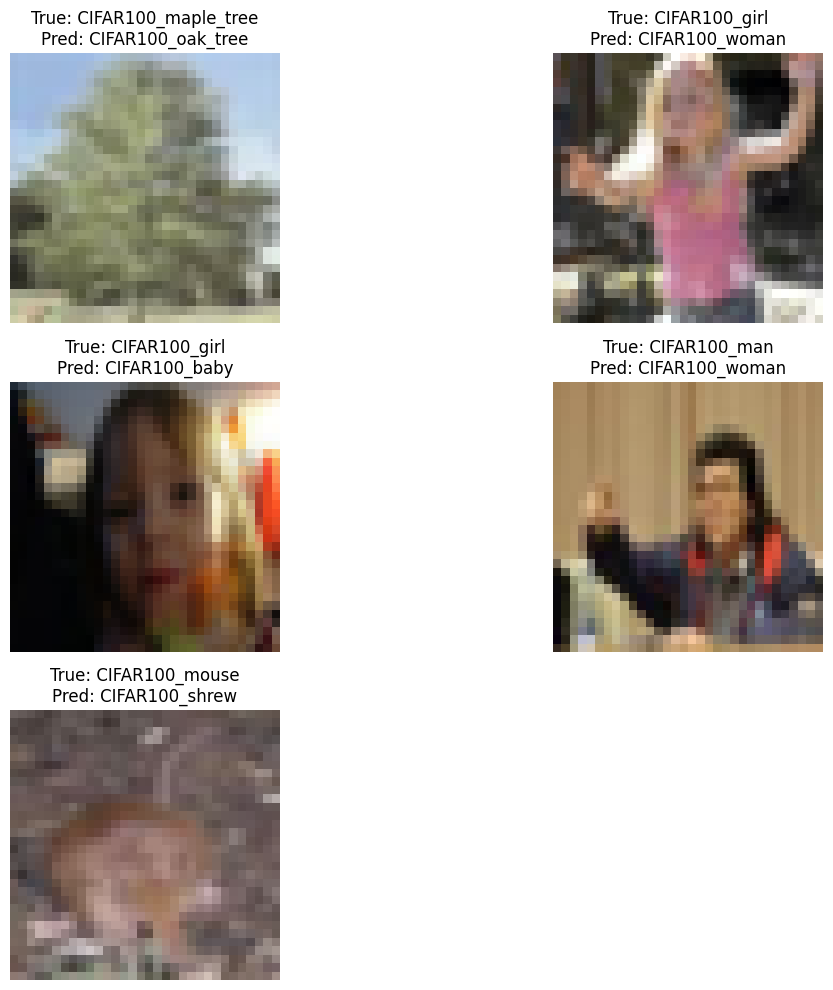

In [ ]:
from PIL import Image
import random
import os

def show_confusion_pair_images(top5, test_set_dir, y_test_np, y_pred_np, idx_to_class):
    temp_test_dataset = datasets.ImageFolder(root=test_set_dir)
    samples = temp_test_dataset.samples  
    
    plt.figure(figsize=(12, 10))
    for i, (true_cls, pred_cls, _) in enumerate(top5):
        true_idx = list(idx_to_class.keys())[list(idx_to_class.values()).index(true_cls)]
        pred_idx = list(idx_to_class.keys())[list(idx_to_class.values()).index(pred_cls)]
        mask = (y_test_np == true_idx) & (y_pred_np == pred_idx)
        indices = np.where(mask)[0]
        if len(indices) == 0:
            print(f"No sample found for pair: {true_cls} -> {pred_cls}")
            continue
        idx = random.choice(indices)
        img_path, _ = samples[idx]
        img = Image.open(img_path)
        plt.subplot(3, 2, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'True: {true_cls}\nPred: {pred_cls}')

    plt.tight_layout()
    plt.show()

show_confusion_pair_images(top5, TEST_SET_DIR, y_test_np, y_pred_np, idx_to_class)

c:\Users\mateo\anaconda3\envs\myenv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


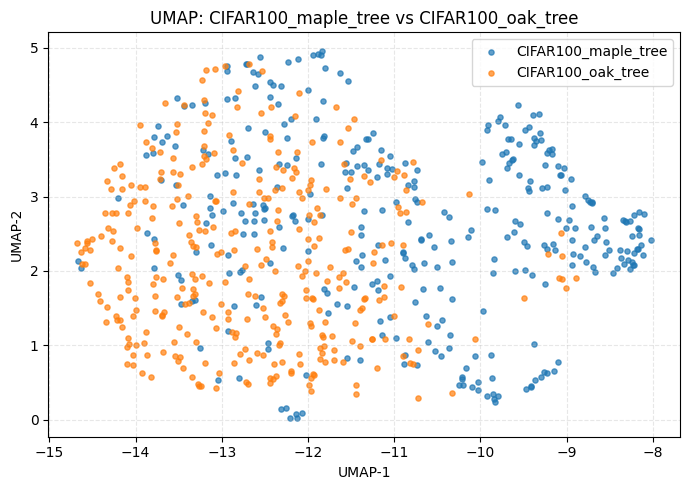

c:\Users\mateo\anaconda3\envs\myenv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


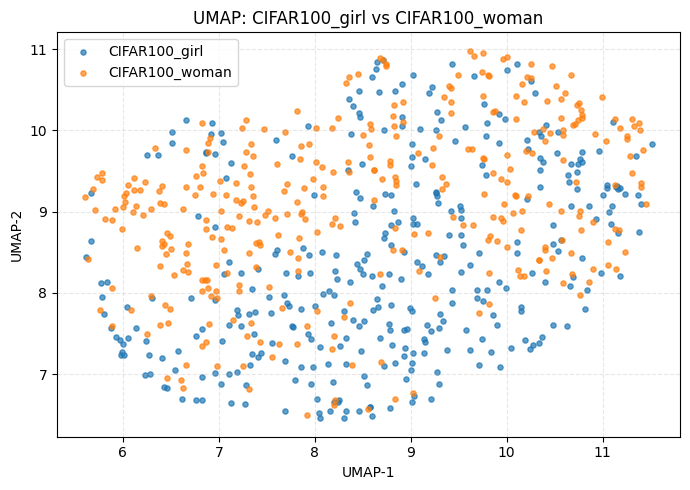

c:\Users\mateo\anaconda3\envs\myenv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


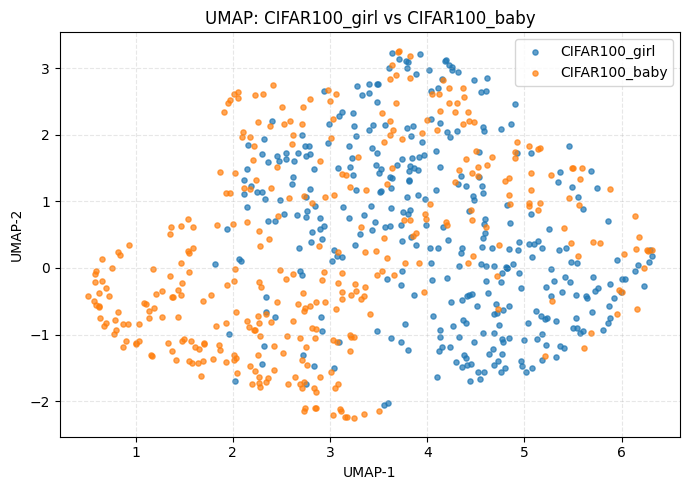

c:\Users\mateo\anaconda3\envs\myenv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


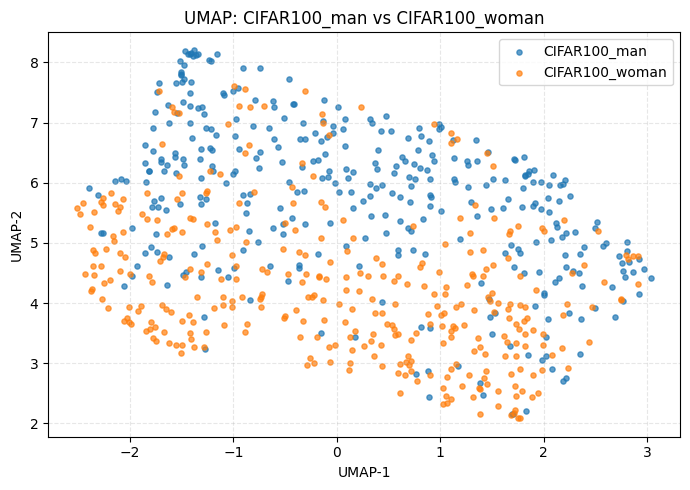

c:\Users\mateo\anaconda3\envs\myenv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


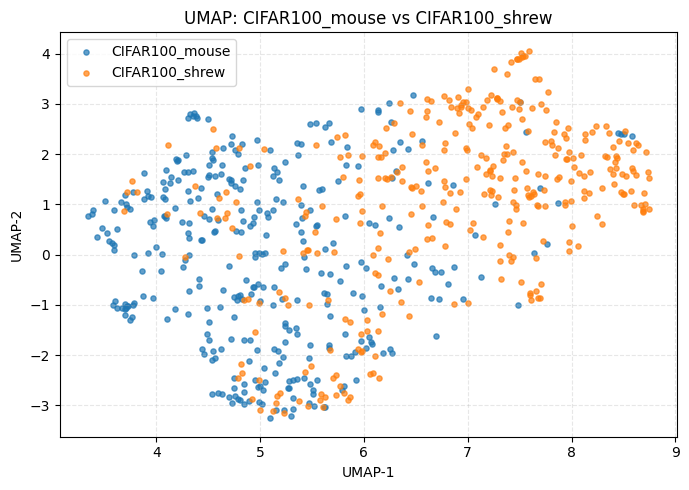

In [19]:
# UMAP visualization for each of the top 5 confusion pairs
import torch
import umap
import matplotlib.pyplot as plt
import numpy as np

# Load DINO embeddings and labels
X_train = torch.load("new_dataset_features/train_X_dino.pt").numpy()
y_train = torch.load("new_dataset_features/train_y.pt").numpy()

class_name_to_idx = {v: k for k, v in idx_to_class.items()}

for i, (true_cls, pred_cls, _) in enumerate(top5):
    true_idx = class_name_to_idx[true_cls] if isinstance(true_cls, str) else true_cls
    pred_idx = class_name_to_idx[pred_cls] if isinstance(pred_cls, str) else pred_cls
    
    # Filter for only these two classes
    mask = np.isin(y_train, [true_idx, pred_idx])
    X_pair = X_train[mask]
    y_pair = y_train[mask]
    
    # UMAP embedding
    reducer = umap.UMAP(
        n_neighbors=30,
        min_dist=0.1,
        metric='cosine',
        random_state=42
)
    X_embedded = reducer.fit_transform(X_pair)
    
    # Plot
    plt.figure(figsize=(7, 5))
    colors = [plt.cm.tab10(0), plt.cm.tab10(1)]
    for idx, color, label in zip([true_idx, pred_idx], colors, [true_cls, pred_cls]):
        plt.scatter(X_embedded[y_pair == idx, 0], X_embedded[y_pair == idx, 1], 
                    c=[color], label=label, s=14, alpha=0.7)
    plt.title(f"UMAP: {true_cls} vs {pred_cls}")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()